In [89]:
import geopandas as gpd
import pandas as pd
import sklearn
from sklearn import cluster
from sklearn.cluster import KMeans
import shapely
from shapely.geometry import Point
from fiona.crs import from_epsg
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
building_shp = gpd.GeoDataFrame.from_file('/nfshome/sz2404/EIAT-Project/Building_Footprint' 
                                     + '/geo_export_e202102f-4f32-4936-b689-4064a6eae238.shp')

In [3]:
building_shp.head()

,geometry
0,POINT (-73.87136418648842 40.6572108924637)
1,POINT (-73.87674308732539 40.71426793029475)
2,POINT (-73.85200650564103 40.66232684433447)
3,POINT (-73.94031864190137 40.641106987106)
4,POINT (-73.98989788468064 40.62387996701545)


In [4]:
# Building points
link = 'https://data.cityofnewyork.us/api/views/msd8-c8zt/rows.csv?accessType=DOWNLOAD'
building_p = pd.read_csv(link)

In [5]:
building_p.head()

,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,BASE_BBL,MPLUTO_BBL,GEOMSOURCE
0,POINT (-73.87136418648842 40.657210892463695),NaN,3394646,2009,08/22/2017 12:00:00 AM +0000,Constructed,1212853,21.608508,2100,18,3044520815,3.044521e+09,Photogramm
1,POINT (-73.8767430873254 40.71426793029475),NaN,4548330,1930,08/17/2017 12:00:00 AM +0000,Constructed,1226227,10.360000,5110,122,4030640041,4.030640e+09,Photogramm
2,POINT (-73.85200650564103 40.66232684433447),NaN,4460479,1960,08/22/2017 12:00:00 AM +0000,Constructed,581946,29.811570,2100,10,4139430001,4.139430e+09,Photogramm
3,POINT (-73.94031864190137 40.641106987106),NaN,3355684,1920,08/17/2017 12:00:00 AM +0000,Constructed,858061,11.200000,5110,32,3049720006,3.049720e+09,Photogramm
4,POINT (-73.98989788468064 40.623879967015455),NaN,3131737,1915,08/22/2017 12:00:00 AM +0000,Constructed,568078,24.980000,2100,44,3055100055,3.055100e+09,Photogramm


In [6]:
building_p.columns

Index(['the_geom', 'NAME', 'BIN', 'CNSTRCT_YR', 'LSTMODDATE', 'LSTSTATYPE',
       'DOITT_ID', 'HEIGHTROOF', 'FEAT_CODE', 'GROUNDELEV', 'BASE_BBL',
       'MPLUTO_BBL', 'GEOMSOURCE'],
      dtype='object')

In [7]:
building_p1 = building_p.drop(['NAME', 'LSTMODDATE', 'LSTSTATYPE',
       'DOITT_ID', 'HEIGHTROOF', 'FEAT_CODE', 'GROUNDELEV', 
       'MPLUTO_BBL', 'GEOMSOURCE'], axis=1)
building_po = building_p1.drop(building_p1[building_p1['CNSTRCT_YR']<1600].index)
building_po = building_po.drop(building_po[building_po['CNSTRCT_YR']>2019].index)

In [8]:
building_po.head()

,the_geom,BIN,CNSTRCT_YR,BASE_BBL
0,POINT (-73.87136418648842 40.657210892463695),3394646,2009,3044520815
1,POINT (-73.8767430873254 40.71426793029475),4548330,1930,4030640041
2,POINT (-73.85200650564103 40.66232684433447),4460479,1960,4139430001
3,POINT (-73.94031864190137 40.641106987106),3355684,1920,3049720006
4,POINT (-73.98989788468064 40.623879967015455),3131737,1915,3055100055


In [9]:
building_po['Age'] = 2019 - building_po.CNSTRCT_YR

In [83]:
building_po_gp = building_po.groupby(['Age'])['BIN'].count()
building_po_gp = pd.DataFrame(building_po_gp).reset_index()
building_po_gp['Number'] = building_po_gp.BIN
building_po_gp.head()

,Age,BIN,Number
0,0,73,73
1,1,1406,1406
2,2,1403,1403
3,3,1458,1458
4,4,910,910


In [10]:
data_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present (2).csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
data_res = data_311[data_311['Complaint Type']=='Noise - Residential']
data_com = data_311[data_311['Complaint Type']=='Noise - Commercial']

In [12]:
data_res.columns, data_com.columns

(Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
        'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
        'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
        'Intersection Street 1', 'Intersection Street 2', 'Address Type',
        'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
        'Resolution Description', 'Resolution Action Updated Date',
        'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
        'Y Coordinate (State Plane)', 'Open Data Channel Type',
        'Park Facility Name', 'Park Borough', 'Vehicle Type',
        'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
        'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
        'Latitude', 'Longitude', 'Location'],
       dtype='object'),
 Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
        'Complaint Type', 'Descriptor', 'Location Type', 

In [13]:
data_res_cl = data_res.drop(['Closed Date', 'Agency', 'Agency Name',
        'Complaint Type', 'Location Type', 'Incident Zip',
        'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
        'Intersection Street 1', 'Intersection Street 2', 'Address Type',
        'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
        'Resolution Description', 'Resolution Action Updated Date',
        'Community Board', 'Borough', 'X Coordinate (State Plane)',
        'Y Coordinate (State Plane)', 'Open Data Channel Type',
        'Park Facility Name', 'Park Borough', 'Vehicle Type',
        'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
        'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
        'Latitude', 'Longitude', 'Location'],axis=1)
data_com_cl = data_com.drop(['Closed Date', 'Agency', 'Agency Name',
        'Complaint Type', 'Location Type', 'Incident Zip',
        'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
        'Intersection Street 1', 'Intersection Street 2', 'Address Type',
        'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
        'Resolution Description', 'Resolution Action Updated Date',
        'Community Board', 'Borough', 'X Coordinate (State Plane)',
        'Y Coordinate (State Plane)', 'Open Data Channel Type',
        'Park Facility Name', 'Park Borough', 'Vehicle Type',
        'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
        'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
        'Latitude', 'Longitude', 'Location'],axis=1)

In [14]:
join_res = pd.merge(data_res_cl, building_po, left_on='BBL', right_on='BASE_BBL')
join_com = pd.merge(data_com_cl, building_po, left_on='BBL', right_on='BASE_BBL')

In [15]:
# Age vs Complain group
#join_res = join_res.drop(['BASE_BBL'],axis=1)
join_res_1 = join_res.groupby(['BIN','CNSTRCT_YR','Age'])['Unique Key'].count()
join_res_1 = pd.DataFrame(join_res_1).reset_index(drop=False)
join_res_1.head()

,BIN,CNSTRCT_YR,Age,Unique Key
0,1000007,1969,50,1
1,1000014,1900,119,4
2,1000020,1987,32,1
3,1000022,1963,56,1
4,1000029,1958,61,1


In [22]:
join_res_1['Count'] = join_res_1['Unique Key']
join_res_cl = join_res_1.drop(['BIN', 'CNSTRCT_YR','Unique Key'], axis=1)

In [49]:
join_com_1 = join_com.groupby(['BIN','CNSTRCT_YR','Age'])['Unique Key'].count()
join_com_1 = pd.DataFrame(join_com_1).reset_index(drop=False)
join_com_1.head()

,BIN,CNSTRCT_YR,Age,Unique Key
0,1000003,1900,119,1
1,1000008,1900,119,2
2,1000020,1987,32,2
3,1000029,1958,61,3
4,1000030,1920,99,1


In [50]:
join_com_1['Count'] = join_com_1['Unique Key']
join_com_cl = join_com_1.drop(['BIN', 'CNSTRCT_YR','Unique Key'], axis=1)

## Clustering

### Residential Clustering

In [23]:
# Residential Clustering
km_res = KMeans(n_clusters=5, random_state=444).fit(join_res_cl)
res_km = km_res.fit_predict(join_res_cl)
join_res_cl['Cluster'] = km_res.labels_
join_res_cl.head()

,Age,Count,Cluster
0,50,1,4
1,119,4,0
2,32,1,4
3,56,1,4
4,61,1,4


In [54]:
join_res_cla = join_res_cl.sort_values(by='Count')
join_res_cla.head()

,Age,Count,Cluster,BIN
0,50,1,4,1000007
66239,114,1,0,3055069
136223,59,1,4,4108397
136224,59,1,4,4108432
136225,54,1,4,4108447


Text(0.5,1,'Residential Cluster: Age vs Noise Complain Count')

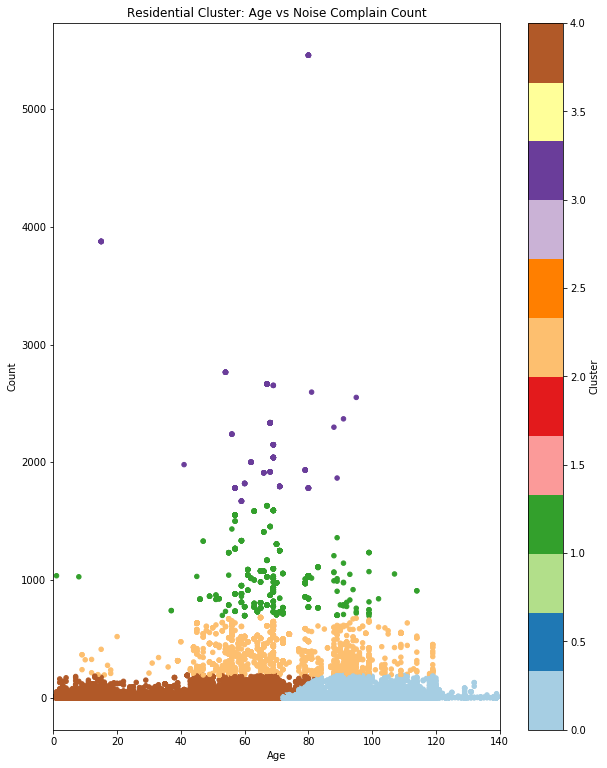

In [48]:
ax = pl.figure(figsize=(10,13)).add_subplot(111)
join_res_cl.plot(kind='scatter', x='Age', y='Count', c='Cluster', ax=ax, colormap='Paired')
pl.xlim(0,140)
pl.title('Residential Cluster: Age vs Noise Complain Count')
#pl.ylim(0,1000)

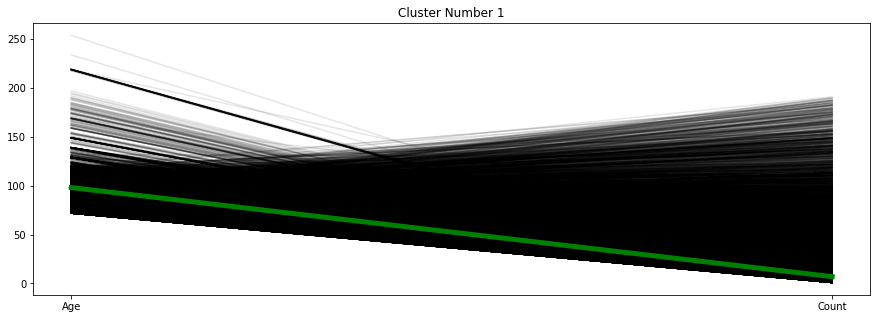

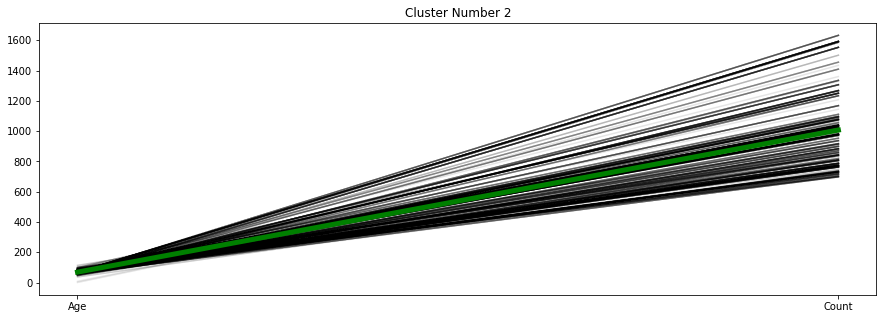

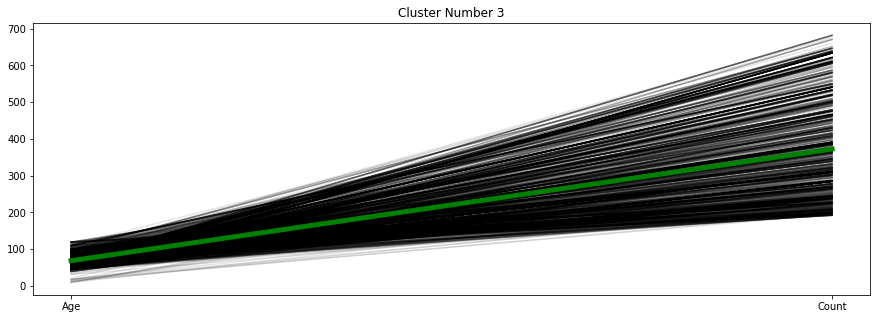

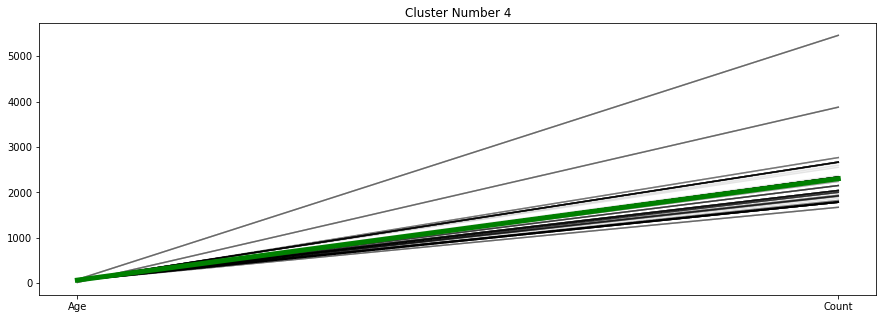

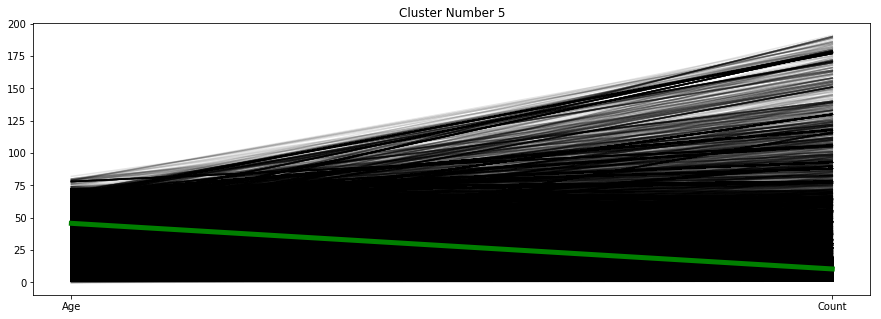

In [25]:
pl.figure(figsize=(15,5))
for i in range (5):
    pl.figure(figsize=(15,5))
    cluster_n = join_res_cl[join_res_cl['Cluster']==i]
    pl.plot(cluster_n.T.iloc[:-1,:], c='black', alpha=0.1)
    pl.plot(km_res.cluster_centers_[i], 'g-', lw=5)
    pl.title('Cluster Number {}'.format(i+1))

### Commercial Clustering

In [51]:
km_com = KMeans(n_clusters=5, random_state=444).fit(join_com_cl)
com_km = km_com.fit_predict(join_com_cl)
join_com_cl['Cluster'] = km_com.labels_
join_com_cl.head()

,Age,Count,Cluster
0,119,1,0
1,119,2,0
2,32,2,3
3,61,3,3
4,99,1,0


Text(0.5,1,'Commercial Cluster: Age vs Noise Complain Count')

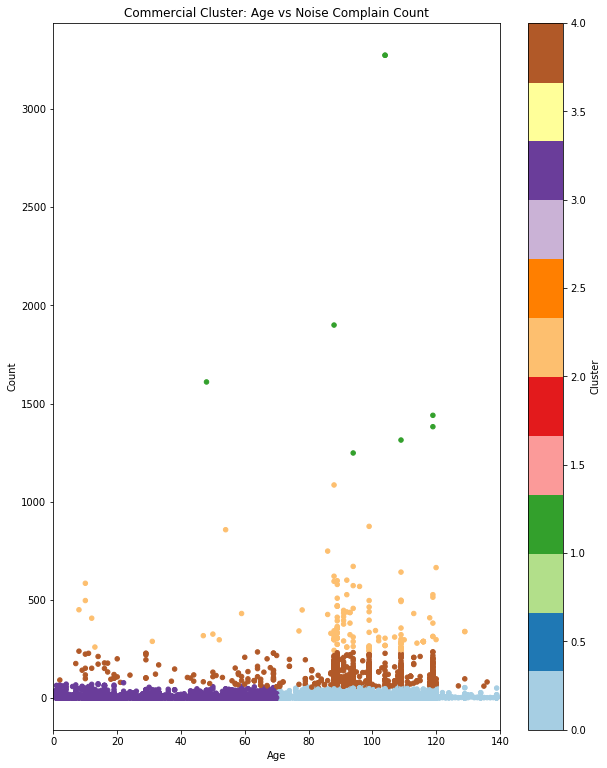

In [80]:
ax = pl.figure(figsize=(10,13)).add_subplot(111)
join_com_cl.plot(kind='scatter', x='Age', y='Count', c='Cluster', ax=ax, colormap='Paired')
pl.xlim(0,140)
pl.title('Commercial Cluster: Age vs Noise Complain Count')

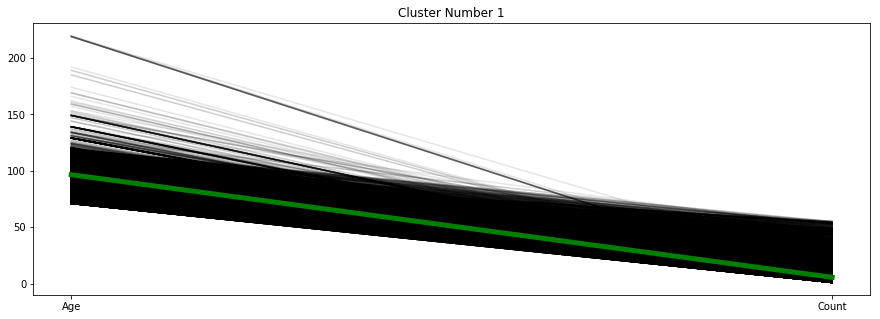

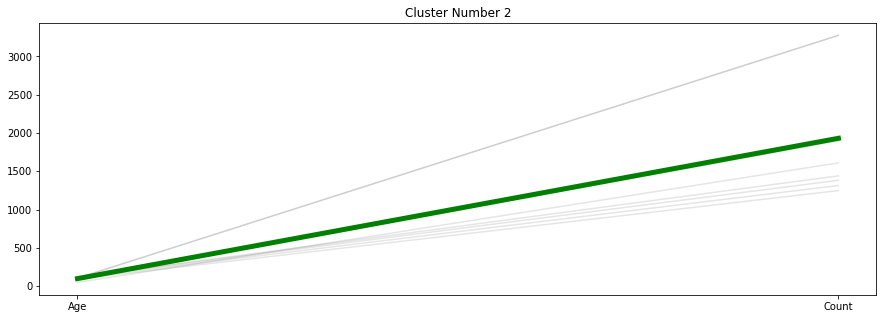

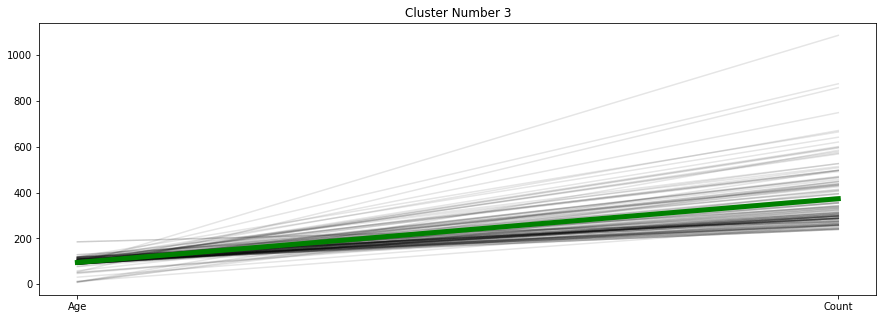

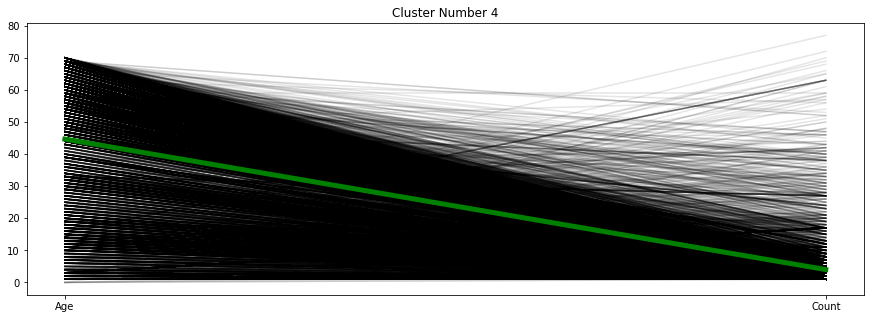

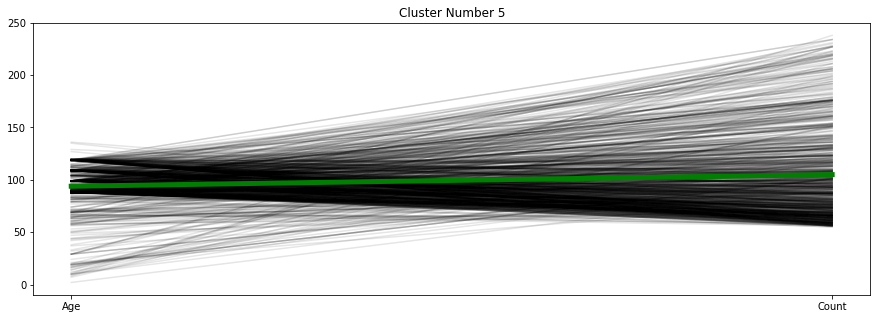

In [53]:
pl.figure(figsize=(15,5))
for i in range (5):
    pl.figure(figsize=(15,5))
    cluster_n = join_com_cl[join_com_cl['Cluster']==i]
    pl.plot(cluster_n.T.iloc[:-1,:], c='black', alpha=0.1)
    pl.plot(km_com.cluster_centers_[i], 'g-', lw=5)
    pl.title('Cluster Number {}'.format(i+1))

## Map Visualization

In [68]:
join_res_cl['BIN'] = join_res_1.BIN
join_com_cl['BIN'] = join_com_1.BIN

In [69]:
geo_res = pd.merge(join_res_cl, building_po, left_on='BIN', right_on='BIN')
geo_com = pd.merge(join_com_cl, building_po, left_on='BIN', right_on='BIN')

In [70]:
geo_res.head(), geo_com.head()

(   Age_x  Count  Cluster      BIN  \
 0     50      1        4  1000007   
 1    119      4        0  1000014   
 2     32      1        4  1000020   
 3     56      1        4  1000022   
 4     61      1        4  1000029   
 
                                         the_geom  CNSTRCT_YR    BASE_BBL  \
 0    POINT (-74.0107212876192 40.70271747402376)        1969  1000050010   
 1   POINT (-74.01108426184408 40.70343970185362)        1900  1000070038   
 2     POINT (-74.0139786591852 40.7028993865665)        1987  1000090014   
 3   POINT (-74.01211885017896 40.70343848947506)        1963  1000100001   
 4  POINT (-74.01263963811104 40.704521309059515)        1958  1000110001   
 
    Age_y  
 0     50  
 1    119  
 2     32  
 3     56  
 4     61  ,    Age_x  Count  Cluster      BIN  \
 0    119      1        0  1000003   
 1    119      2        0  1000008   
 2     32      2        3  1000020   
 3     61      3        3  1000029   
 4     99      1        0  1000030   
 
    

In [71]:
geo_res['new'] = geo_res['the_geom'].apply(lambda x: x.replace('POINT ', ''))
geo_res['new1'] = geo_res['new'].apply(lambda x: x.replace('(', ''))
geo_res['new2'] = geo_res['new1'].apply(lambda x: x.replace(')', ''))
geo_res['new3'] = geo_res['new2'].apply(lambda x: x.replace(' ', ', '))
geo_res['lon'] = geo_res['new3'].str.split(',').str[0].astype(float)
geo_res['lat'] = geo_res['new3'].str.split(',').str[1].astype(float)
geo_res['coor'] = list(zip(geo_res['lon'], geo_res['lat']))
geo_res.head()

,Age_x,Count,Cluster,BIN,the_geom,CNSTRCT_YR,BASE_BBL,Age_y,new,new1,new2,new3,lon,lat,coor
0,50,1,4,1000007,POINT (-74.0107212876192 40.70271747402376),1969,1000050010,50,(-74.0107212876192 40.70271747402376),-74.0107212876192 40.70271747402376),-74.0107212876192 40.70271747402376,"-74.0107212876192, 40.70271747402376",-74.010721,40.702717,"(-74.0107212876192, 40.70271747402376)"
1,119,4,0,1000014,POINT (-74.01108426184408 40.70343970185362),1900,1000070038,119,(-74.01108426184408 40.70343970185362),-74.01108426184408 40.70343970185362),-74.01108426184408 40.70343970185362,"-74.01108426184408, 40.70343970185362",-74.011084,40.703440,"(-74.01108426184408, 40.70343970185362)"
2,32,1,4,1000020,POINT (-74.0139786591852 40.7028993865665),1987,1000090014,32,(-74.0139786591852 40.7028993865665),-74.0139786591852 40.7028993865665),-74.0139786591852 40.7028993865665,"-74.0139786591852, 40.7028993865665",-74.013979,40.702899,"(-74.0139786591852, 40.7028993865665)"
3,56,1,4,1000022,POINT (-74.01211885017896 40.70343848947506),1963,1000100001,56,(-74.01211885017896 40.70343848947506),-74.01211885017896 40.70343848947506),-74.01211885017896 40.70343848947506,"-74.01211885017896, 40.70343848947506",-74.012119,40.703438,"(-74.01211885017896, 40.70343848947506)"
4,61,1,4,1000029,POINT (-74.01263963811104 40.704521309059515),1958,1000110001,61,(-74.01263963811104 40.704521309059515),-74.01263963811104 40.704521309059515),-74.01263963811104 40.704521309059515,"-74.01263963811104, 40.704521309059515",-74.012640,40.704521,"(-74.01263963811104, 40.704521309059515)"


In [72]:
geo_com['new'] = geo_com['the_geom'].apply(lambda x: x.replace('POINT ', ''))
geo_com['new1'] = geo_com['new'].apply(lambda x: x.replace('(', ''))
geo_com['new2'] = geo_com['new1'].apply(lambda x: x.replace(')', ''))
geo_com['new3'] = geo_com['new2'].apply(lambda x: x.replace(' ', ', '))
geo_com['lon'] = geo_com['new3'].str.split(',').str[0].astype(float)
geo_com['lat'] = geo_com['new3'].str.split(',').str[1].astype(float)
geo_com['coor'] = list(zip(geo_com['lon'], geo_com['lat']))
geo_com.head()

,Age_x,Count,Cluster,BIN,the_geom,CNSTRCT_YR,BASE_BBL,Age_y,new,new1,new2,new3,lon,lat,coor
0,119,1,0,1000003,POINT (-74.01165367525687 40.70104684516938),1900,1000020002,119,(-74.01165367525687 40.70104684516938),-74.01165367525687 40.70104684516938),-74.01165367525687 40.70104684516938,"-74.01165367525687, 40.70104684516938",-74.011654,40.701047,"(-74.01165367525687, 40.70104684516938)"
1,119,2,0,1000008,POINT (-74.01102275825262 40.70329440926431),1900,1000070027,119,(-74.01102275825262 40.70329440926431),-74.01102275825262 40.70329440926431),-74.01102275825262 40.70329440926431,"-74.01102275825262, 40.70329440926431",-74.011023,40.703294,"(-74.01102275825262, 40.70329440926431)"
2,32,2,3,1000020,POINT (-74.0139786591852 40.7028993865665),1987,1000090014,32,(-74.0139786591852 40.7028993865665),-74.0139786591852 40.7028993865665),-74.0139786591852 40.7028993865665,"-74.0139786591852, 40.7028993865665",-74.013979,40.702899,"(-74.0139786591852, 40.7028993865665)"
3,61,3,3,1000029,POINT (-74.01263963811104 40.704521309059515),1958,1000110001,61,(-74.01263963811104 40.704521309059515),-74.01263963811104 40.704521309059515),-74.01263963811104 40.704521309059515,"-74.01263963811104, 40.704521309059515",-74.012640,40.704521,"(-74.01263963811104, 40.704521309059515)"
4,99,1,0,1000030,POINT (-74.01249216417052 40.704818748786494),1920,1000110007,99,(-74.01249216417052 40.704818748786494),-74.01249216417052 40.704818748786494),-74.01249216417052 40.704818748786494,"-74.01249216417052, 40.704818748786494",-74.012492,40.704819,"(-74.01249216417052, 40.704818748786494)"


In [73]:
geo_res['geometry'] = geo_res[['coor']].applymap(lambda x:shapely.geometry.Point(x)) 
geo_com['geometry'] = geo_com[['coor']].applymap(lambda x:shapely.geometry.Point(x)) 

In [74]:
geo_res = gpd.GeoDataFrame(geo_res,geometry = 'geometry')
geo_com = gpd.GeoDataFrame(geo_com,geometry = 'geometry')

In [76]:
shp = '/nfshome/sz2404/EIAT-Project' + '/PP/' + 'geo_export_4b1be2c4-8b32-4128-8581-6c9efbfacf70.shp'
area = gpd.GeoDataFrame.from_file(shp)
area.head(), area.crs

(   precinct    shape_area    shape_leng  \
 0       1.0  4.730176e+07  80586.154615   
 1       5.0  1.808880e+07  18676.124259   
 2       6.0  2.209819e+07  26402.900669   
 3      71.0  4.533179e+07  29978.094261   
 4      72.0  1.046213e+08  87968.194520   
 
                                             geometry  
 0  (POLYGON ((-74.0438776157395 40.69018767637665...  
 1  POLYGON ((-73.98863862848766 40.72293372026369...  
 2  POLYGON ((-73.99968392160721 40.73855224865976...  
 3  POLYGON ((-73.92854313809303 40.66457328584737...  
 4  POLYGON ((-73.99840899113158 40.67186872303234...  , {'init': 'epsg:4326'})

In [77]:
geo_res.crs = from_epsg(4326)
geo_com.crs = from_epsg(4326)

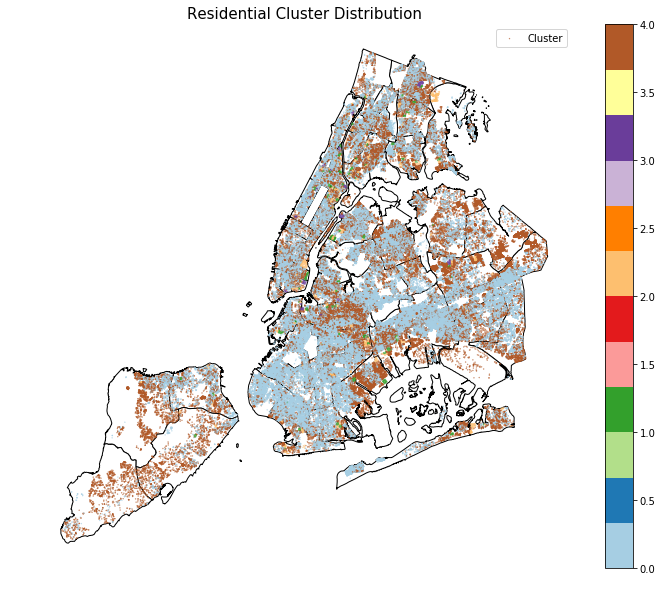

In [98]:
ax = pl.figure(figsize=(12,10)).add_subplot(111)

area.plot(facecolor='w', ax=ax, edgecolor='black')
geo_res.plot(label='Cluster', column='Cluster', cmap='Paired', ax=ax, markersize=0.1, legend=True)
ax.set_title('Residential Cluster Distribution', fontsize=15)
ax.axis('off')
ax.legend()
#.set_bbox_to_anchor((0.2,0.9,0.1,0))

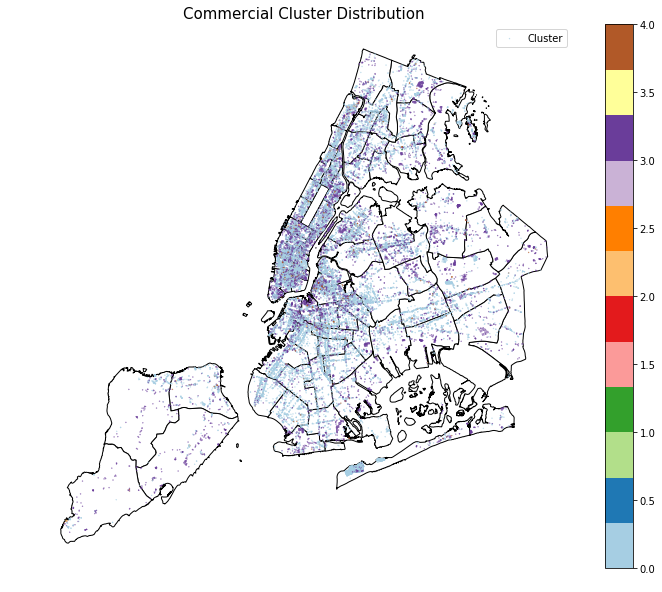

In [79]:
ax = pl.figure(figsize=(12,10)).add_subplot(111)

area.plot(facecolor='w', ax=ax, edgecolor='black')
geo_com.plot(label='Cluster', column='Cluster', cmap='Paired', ax=ax, markersize=0.1, legend=True)
ax.set_title('Commercial Cluster Distribution', fontsize=15)
ax.axis('off')
ax.legend()

## Linear Regression

In [85]:
# Merging
join_com_lin = pd.DataFrame(join_com_cl.groupby(['Age'])['Count'].sum()).reset_index()
lin_com = pd.merge(join_com_lin, building_po_gp, left_on='Age', right_on='Age')
join_res_lin = pd.DataFrame(join_res_cl.groupby(['Age'])['Count'].sum()).reset_index()
lin_res = pd.merge(join_res_lin, building_po_gp, left_on='Age', right_on='Age')

In [87]:
lin_com['Count_Norm'] = lin_com['Count']/lin_com['Number']
lin_res['Count_Norm'] = lin_res['Count']/lin_res['Number']

In [90]:
ols_com = smf.ols(formula='Count_Norm~Age', data=lin_com).fit()
ols_res = smf.ols(formula='Count_Norm~Age', data=lin_res).fit()
ols_com.summary(), ols_res.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:             Count_Norm   R-squared:                       0.055
 Model:                            OLS   Adj. R-squared:                  0.049
 Method:                 Least Squares   F-statistic:                     9.278
 Date:                Wed, 08 May 2019   Prob (F-statistic):            0.00272
 Time:                        14:27:06   Log-Likelihood:                -478.87
 No. Observations:                 160   AIC:                             961.7
 Df Residuals:                     158   BIC:                             967.9
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
 ---------------------------------------------------------------------

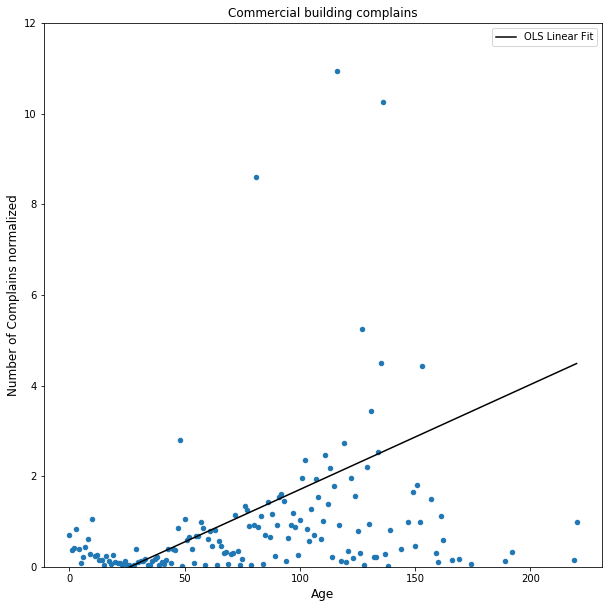

In [95]:
lin_com.plot(kind='scatter', y='Count_Norm', x='Age', figsize=(10,10))
pl.plot(lin_com.Age, ols_com.predict(lin_com), 'k', label='OLS Linear Fit')
pl.ylim(0,12)
pl.xlabel('Age', fontsize=12)
pl.ylabel('Number of Complains normalized', fontsize=12)
pl.title('Commercial building complains', fontsize=12)
pl.legend()

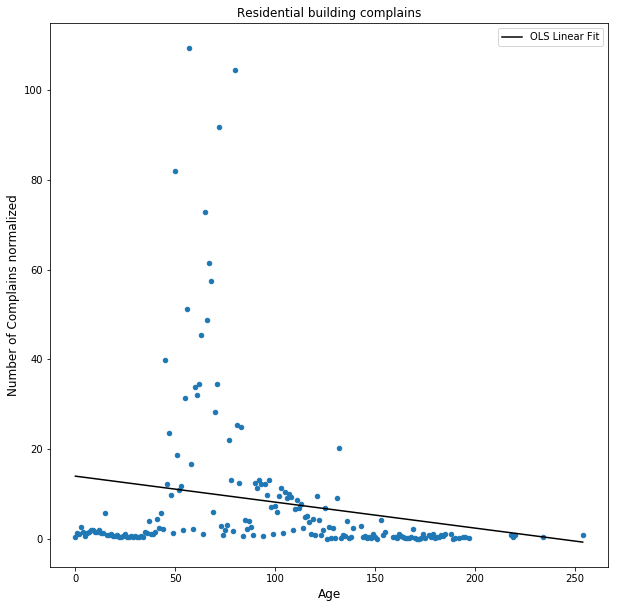

In [97]:
lin_res.plot(kind='scatter', y='Count_Norm', x='Age', figsize=(10,10))
pl.plot(lin_res.Age, ols_res.predict(lin_res), 'k', label='OLS Linear Fit')
#pl.ylim(0,12)
pl.xlabel('Age', fontsize=12)
pl.ylabel('Number of Complains normalized', fontsize=12)
pl.title('Residential building complains', fontsize=12)
pl.legend()